In [68]:
!pip install ffmpeg-python Pillow

In [69]:
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from IPython.display import display
import ffmpeg
import shutil


def extract_frames(video_path, output_folder, interval):
    ffmpeg.input(video_path, ss=0).output(
        f"{output_folder}frame_%03d.png", vf=f"fps=1/{interval}"
    ).run()


def composite_frames(
    video_path,
    output_composite,
    start_frame,
    end_frame=None,
    enhancement=5,
    frame_interval=0.6,  # 0.6 * 100x speed up == 60 seconds
    temp_folder="temp_frames/",
):
    os.makedirs(temp_folder, exist_ok=True)
    extract_frames(video_path, temp_folder, frame_interval)

    frame_paths = sorted(
        [
            os.path.join(temp_folder, f)
            for f in os.listdir(temp_folder)
            if f.endswith(".png")
        ]
    )
    print(f"Total frames available: {len(frame_paths)}")

    num_samples = min(10, len(frame_paths))
    sample_indices = [
        int(i * len(frame_paths) / num_samples) for i in range(num_samples)
    ]

    plt.figure(figsize=(15, 4))
    for i, idx in enumerate(sample_indices):
        plt.subplot(1, num_samples, i + 1)
        frame = Image.open(frame_paths[idx])
        plt.imshow(np.array(frame))
        plt.title(f"Frame {idx}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

    if end_frame is None:
        end_frame = len(frame_paths)

    start_frame = max(0, start_frame)
    end_frame = min(len(frame_paths), end_frame)
    print(f"Analyzing frames {start_frame} to {end_frame-1}")
    print(f"Total frames used: {end_frame - start_frame}")

    results = analyze_frames(frame_paths, enhancement, start_frame, end_frame)

    first_frame_path = frame_paths[start_frame]
    last_frame_path = frame_paths[end_frame - 1]
    first_frame = Image.open(first_frame_path)
    last_frame = Image.open(last_frame_path)
    first_frame.save(output_composite + f"first_frame_{start_frame}_min.png")
    last_frame.save(output_composite + f"final_frame_{end_frame-1}_min.png")

    results["median"].save(output_composite + "median.png")
    results["max_projection"].save(output_composite + "max_projection.png")
    for filename in os.listdir(temp_folder):
        file_path = os.path.join(temp_folder, filename)
        if os.path.isdir(file_path):
            shutil.rmtree(file_path)
        else:
            os.remove(file_path)

    shutil.rmtree(temp_folder)

def analyze_frames(frame_paths, enhacement = 5, start_idx=0, end_idx=None):
    """
    frame_paths: List of paths to frame images
    start_idx: Index of first frame to include (0-based)
    end_idx: Index of last frame to include (or None to use all frames)
    """
    selected_paths = frame_paths[start_idx:end_idx]
    frames = [np.array(Image.open(path).convert("RGB")) for path in selected_paths]
    frames_float = [frame.astype(np.float32) for frame in frames]

    median_frame = np.median(frames_float, axis=0).astype(np.uint8)
    plt.figure(figsize=(10, 8))
    plt.imshow(median_frame)
    plt.title("Median Frame (Background)")
    plt.show()

    max_projection = np.max(frames_float, axis=0).astype(np.uint8)
    plt.figure(figsize=(10, 8))
    plt.imshow(max_projection)
    plt.title(f"Maximum Intensity Projection (Frames {start_idx}-{end_idx-1})")
    plt.show()

    plt.figure(figsize=(15, 15))
    num_frames_to_show = min(4, len(frames))
    step = len(frames) // num_frames_to_show if len(frames) > num_frames_to_show else 1

    for i in range(0, len(frames), step):
        if i // step >= num_frames_to_show:
            break

        # Calculate absolute difference
        diff = np.abs(frames_float[i] - median_frame)

        # Scale differences for better visualization
        enhanced_diff = np.clip(diff * enhacement, 0, 255).astype(np.uint8)

        # Display original frame
        plt.subplot(num_frames_to_show, 3, (i // step) * 3 + 1)
        plt.imshow(frames[i])
        plt.title(f"Frame {start_idx + i}")
        plt.axis("off")

        # Display difference
        plt.subplot(num_frames_to_show, 3, (i // step) * 3 + 2)
        plt.imshow(enhanced_diff)
        plt.title(f"Difference (enhanced 5x)")
        plt.axis("off")

        # Create heatmap of differences
        diff_heat = np.sum(diff, axis=2)  # Sum across RGB channels
        plt.subplot(num_frames_to_show, 3, (i // step) * 3 + 3)
        plt.imshow(diff_heat, cmap="hot")
        plt.title(f"Difference Heatmap")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    # Calculate variance across frames
    variance = np.var(frames_float, axis=0)
    variance_sum = np.sum(variance, axis=2)

    # Normalize and visualize variance
    variance_normalized = variance_sum / (np.max(variance_sum) + 1e-5)
    plt.figure(figsize=(10, 8))
    plt.imshow(variance_normalized, cmap="hot")
    plt.colorbar()
    plt.title("Variance Across Frames (Areas of Change)")
    plt.show()

    # Return processed images
    results = {
        "median": Image.fromarray(median_frame),
        "max_projection": Image.fromarray(max_projection),
        "variance_map": variance_normalized,
    }

    return results

ffmpeg version 7.0.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/7.0.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --ena

Total frames available: 75


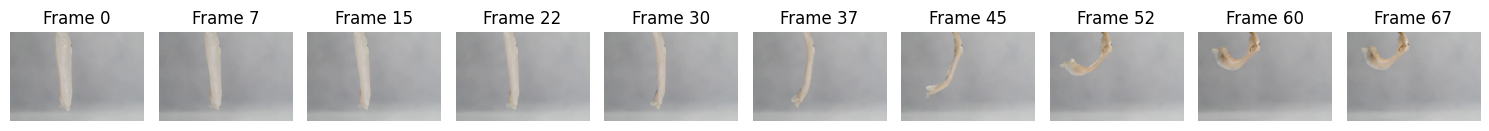

Analyzing frames 22 to 59
Total frames used: 38


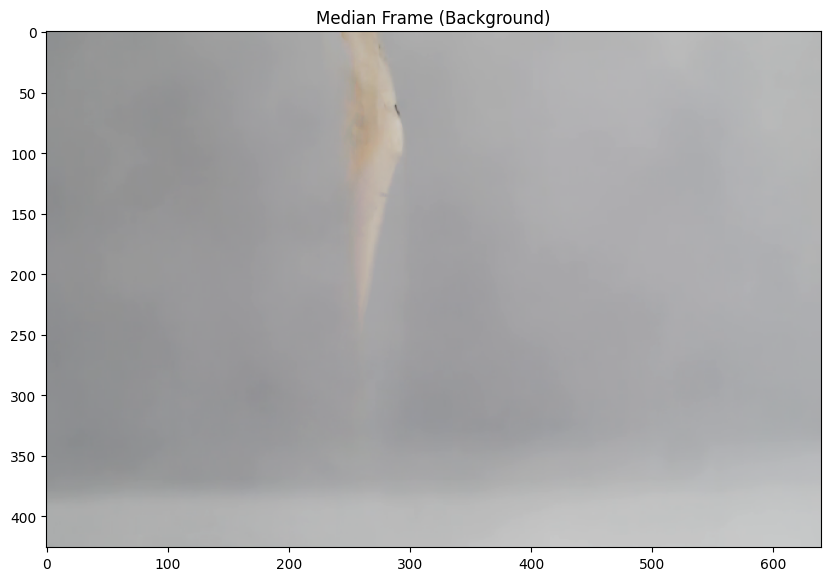

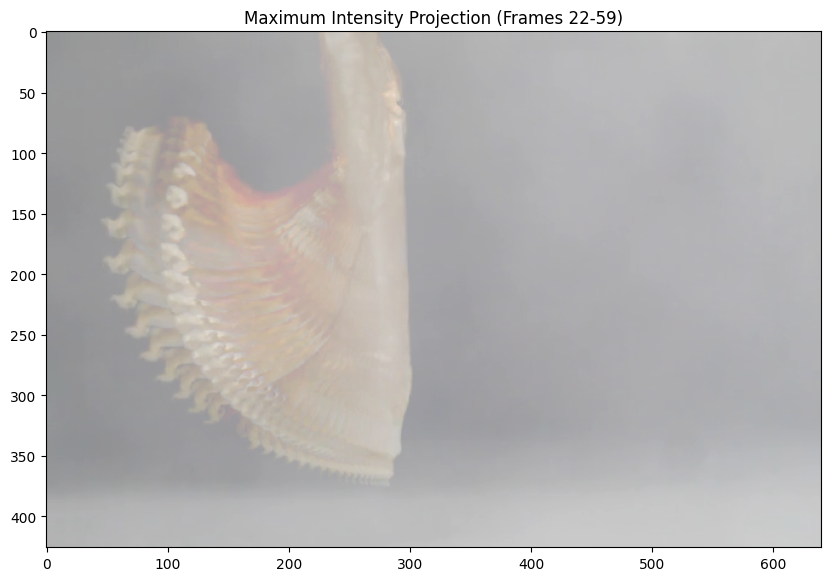

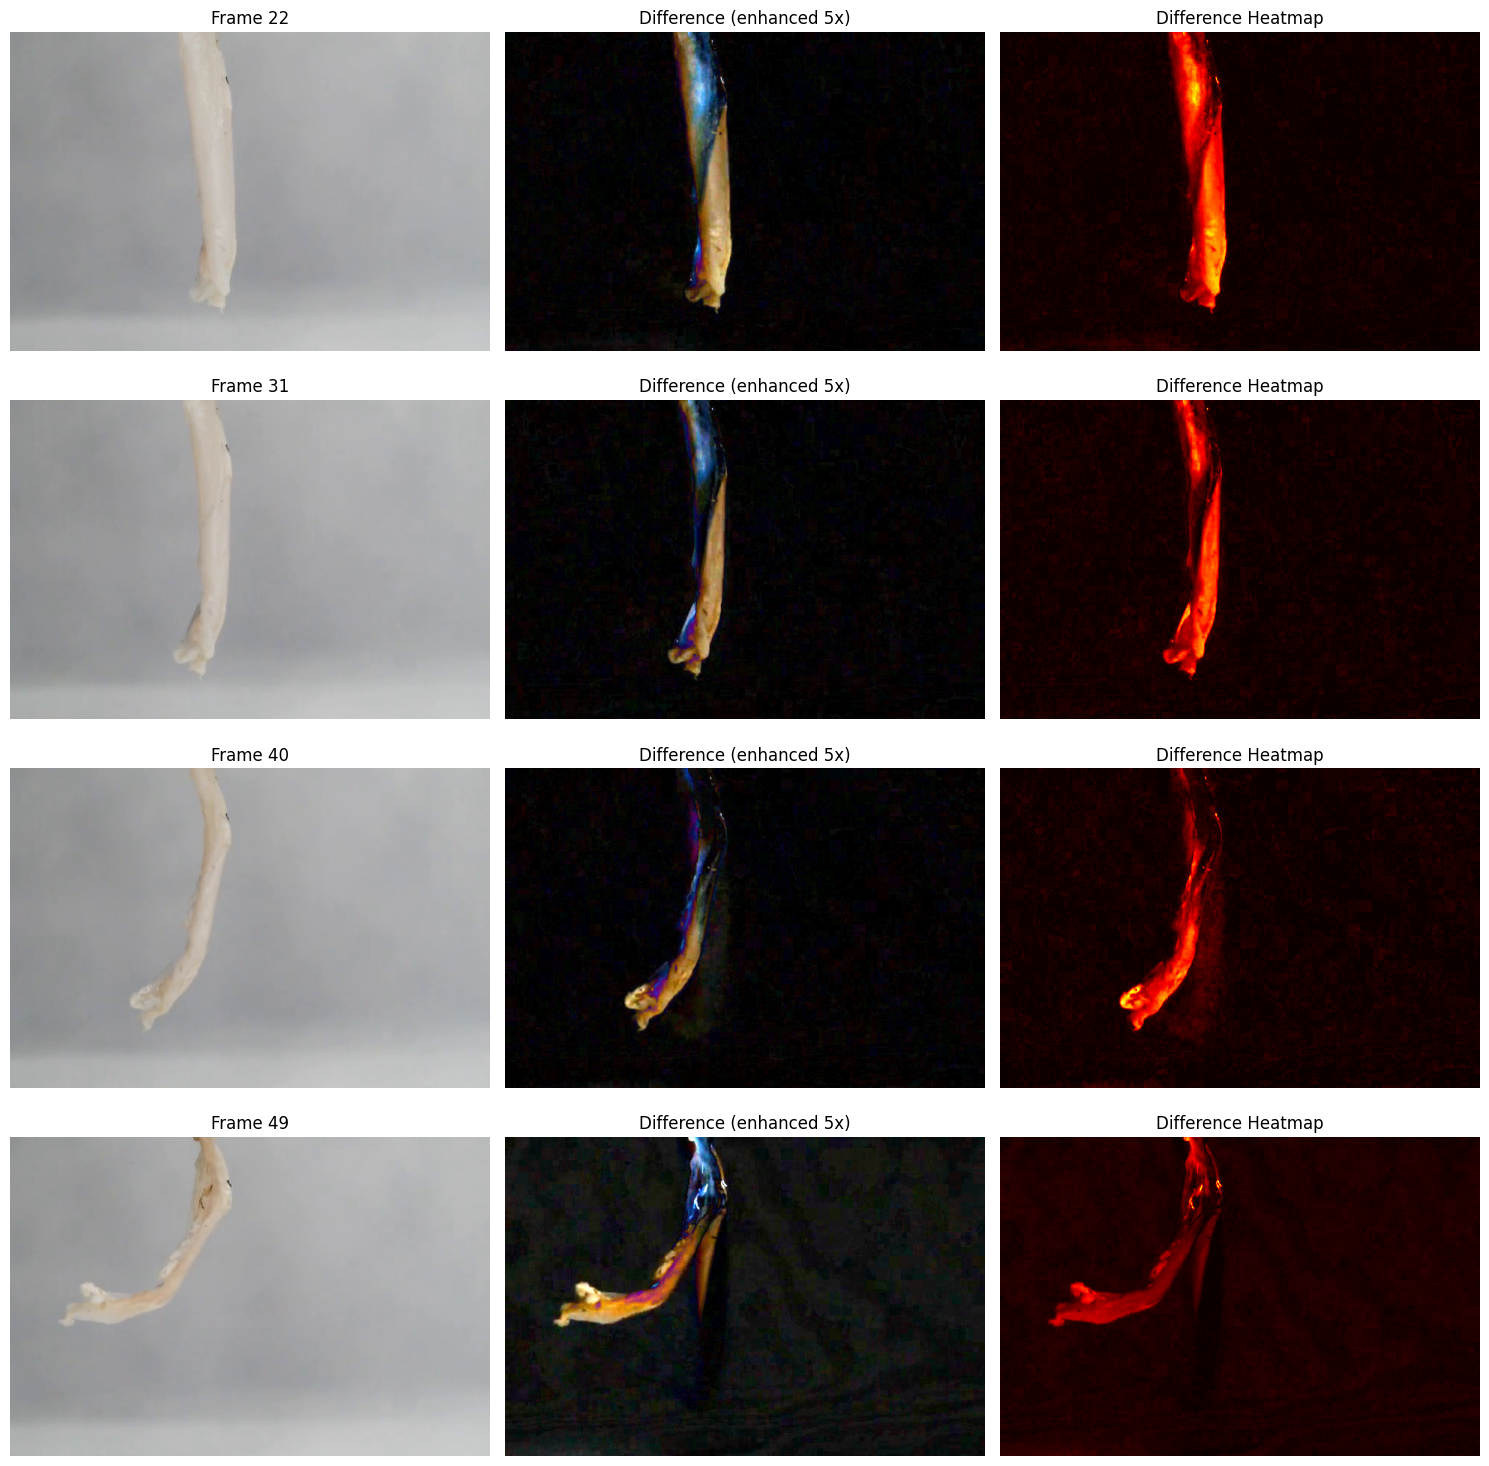

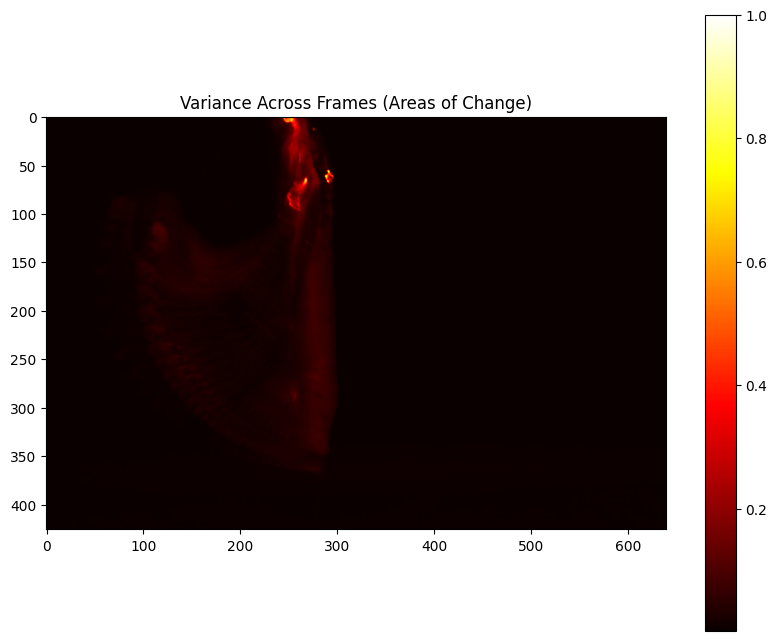

In [70]:
# Set paths
video_path = "bimorph_videos/03.21.25_idx1_100x.mov"
temp_folder = "frames/"
composite_name = "bimorph_frame_composites/03.21.25_idx1_1min_intervals"
start_frame = 22
end_frame = 60
enhancement = 5

composite_frames(
    video_path=video_path,
    output_composite=composite_name,
    start_frame=start_frame,
    end_frame=end_frame,
    enhancement=enhancement,
    frame_interval=0.6,
)

ffmpeg version 7.0.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/7.0.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --ena

Total frames available: 2


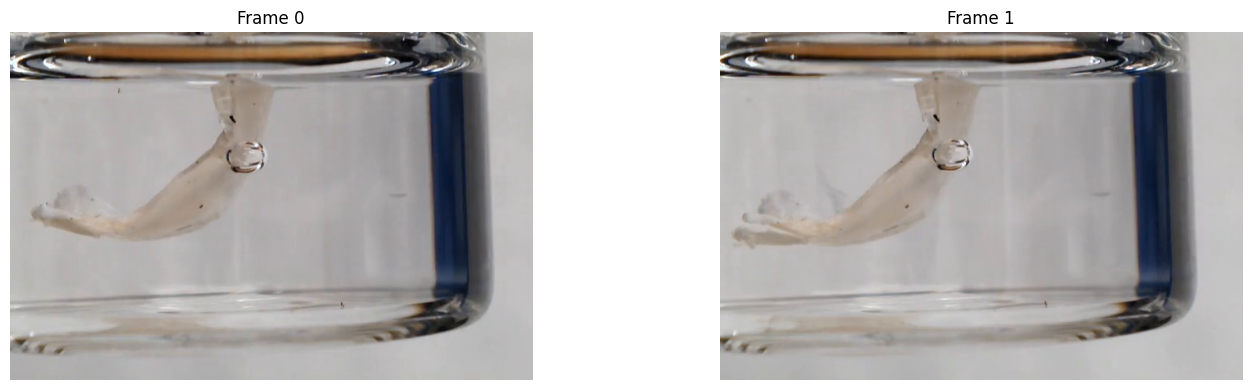

Analyzing frames 0 to 1
Total frames used: 2


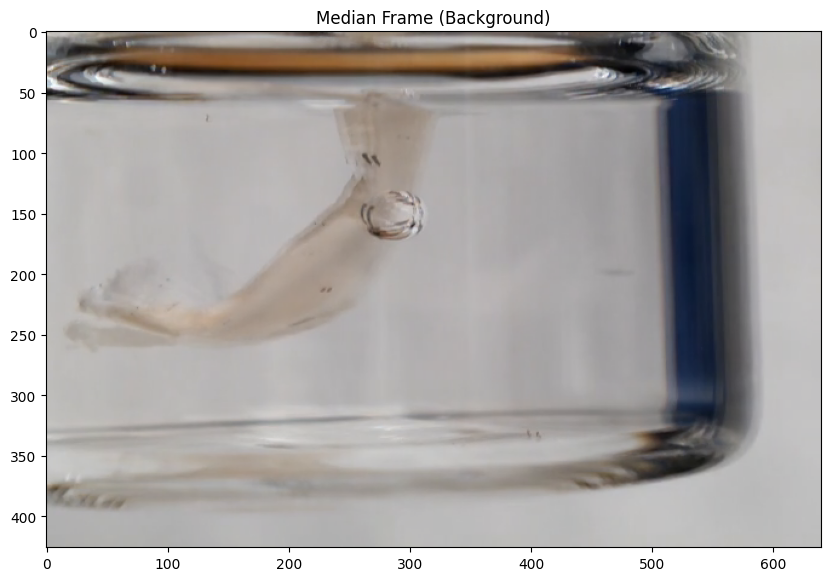

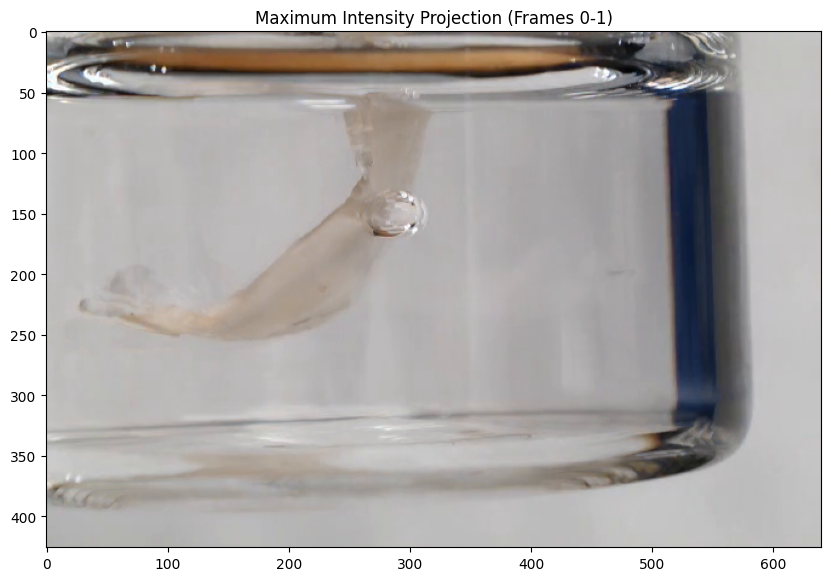

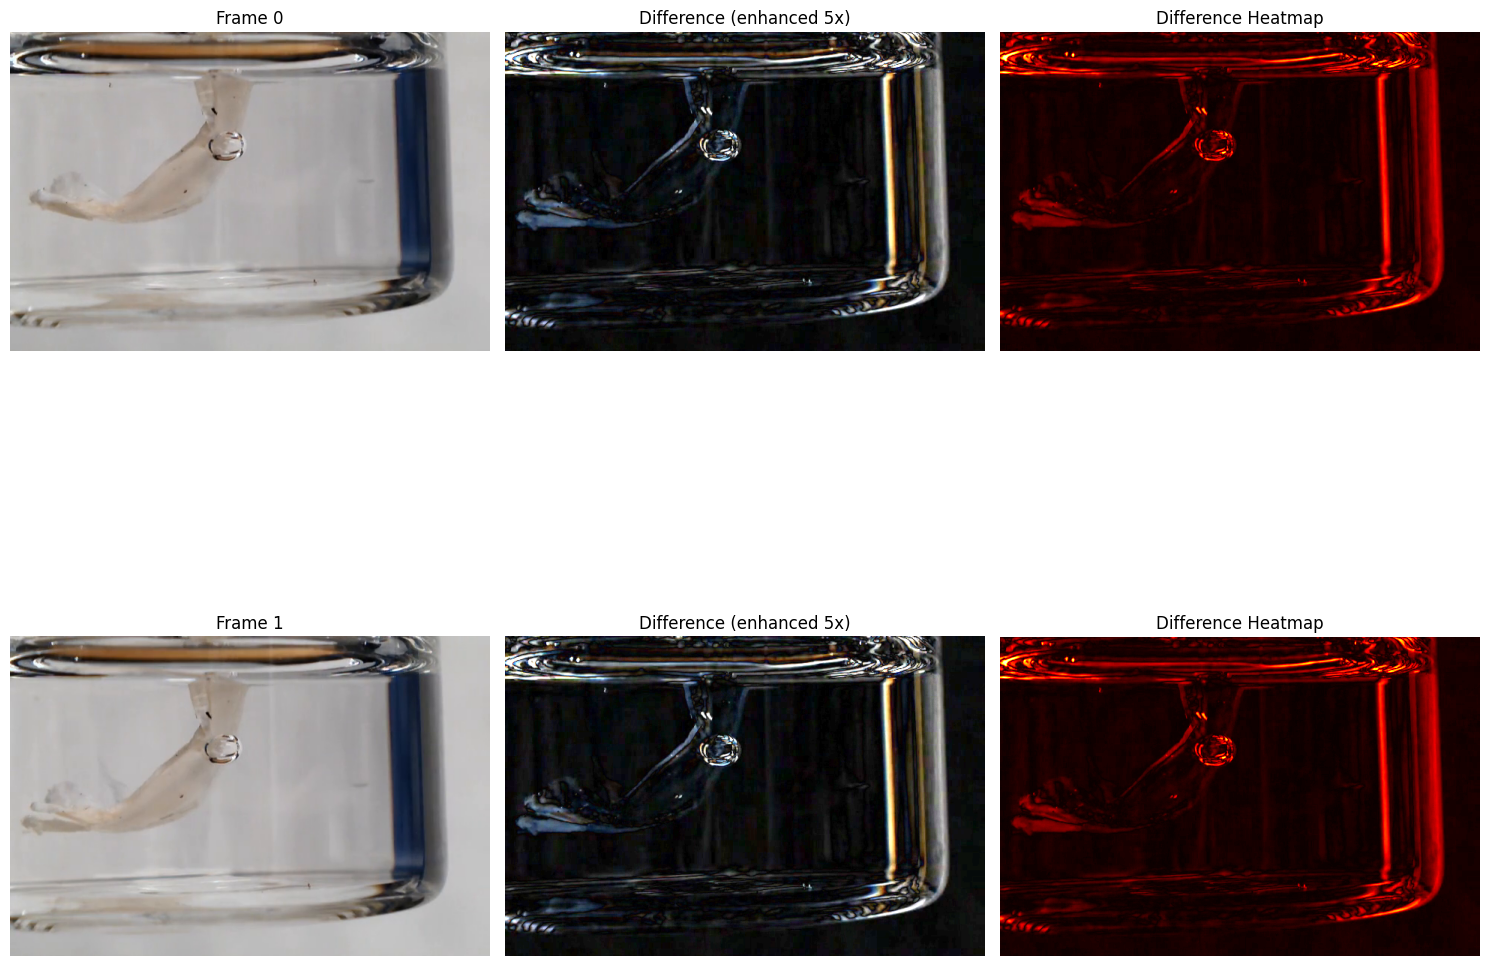

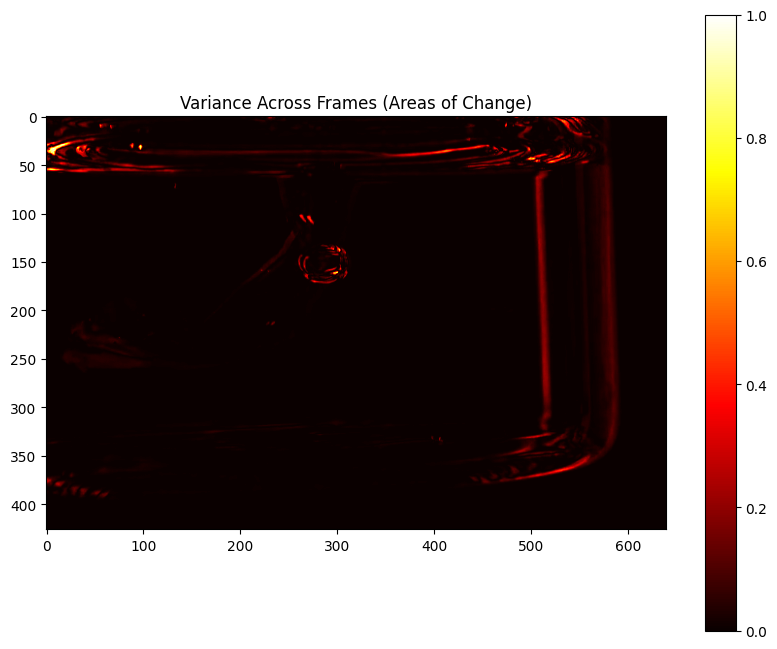

In [71]:
# Set paths
video_path = "bimorph_videos/03.22.25_idx0_rehydration_100x.mov"
composite_name = "bimorph_frame_composites/03.22.25_idx0_rehydration_30min_interval"
start_frame = 0
end_frame = 2
enhancement = 5

composite_frames(
    video_path=video_path,
    output_composite=composite_name,
    start_frame=start_frame,
    end_frame=end_frame,
    enhancement=enhancement,
    frame_interval=0.6 * 30, # 5 minute intervals
)